In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from network import *
import matplotlib.pyplot as plt

In [2]:
TRANSITION = 0.9
B_DURATION = 4
DIS_COST_SCALE = 5
STORAGE_RATIO = 1

First, read in problem parameters. These can come from any source, but they should be reshaped into a `pandas.DataFrame` object with the format shown here

In [3]:
input = pd.read_excel('test_case_inputs.xlsx', sheet_name=None)

In [4]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

# Installed generation capacities
installed = np.array(input['Gen']['Installed MW'])

# The initial conditions of the demand curves
load = input['LoadProfiles'].set_index('Datetime')
load = load.drop(columns=['Date','HE'])
demand = load.loc[:,load.columns.str.contains('Load')]/base
demand.columns = demand.columns.str.replace('Load','').astype(int)
price = load.loc[:,load.columns.str.contains('Price')]
price.columns = price.columns.str.replace('Price','').astype(int)
price = price*base

# Generation profiles for intermittant sources
int_gen = input['NormGenProfiles'].set_index('Datetime')
int_gen = int_gen.loc[load.index, input['Gen']['Type']]
int_gen = int_gen*installed/base
int_gen.columns = np.array(input['Gen']['Number of Bus'])

# Set elasticity constant, for now
epsilon = demand.copy()
epsilon[:] = -.7

voll = price.copy()
voll[:] = base*1000

profile = pd.concat(
    {
        'nom_load': demand,
        'nom_price': price,
        'elasticity': epsilon,
        'voll': voll,
        'int_gen': int_gen
    },
    axis='columns'
)

profile.int_gen = TRANSITION*profile.int_gen

# Process Ybus matrix
Y = input['YBus']
Y = Y.drop(columns=['Number'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = input['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# Dispatchable generator costs, in the form [linear; quadratic]
cost_coeffs = DIS_COST_SCALE*np.array(
    [
        [10,8,12],
        [.016,0.18,0.18]
    ]
)
cost_coeffs = [[base],[base^2]]*cost_coeffs

# Generator limits
dis_max = installed/base

# Total storage capacity
total_storage = STORAGE_RATIO*installed.sum()/base

# Single-day run
profile = profile.loc[profile.index.day == profile.index.day[0]]

C:\Users\elean\AppData\Local\Temp\ipykernel_12012\2199209321.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Y = Y.applymap(complex)


Instantiate model

In [5]:
model = Network(
    B=B,
    line_lims=P_line,
    profile=profile,
    dis_max=(1-TRANSITION)*dis_max,
    total_storage=TRANSITION*total_storage,
    storage_cycle_timesteps=B_DURATION,
    cost_coeffs=cost_coeffs,
    cycle_storage=True
)
model.profile.int_gen *= TRANSITION

def reset_to_nominal():
    '''resets the model to have nominal values - make sure anything being varied has its nominal value specified here.'''
    model.profile.elasticity = -0.7
    model.profile.int_gen = TRANSITION*profile.int_gen
    model.dis_max = (1-TRANSITION)*dis_max
    model.line_lims = P_line
    model.total_storage = TRANSITION*total_storage 
    model.cost_coeffs = cost_coeffs

Solve model. This will add output data to the `model.profile` dataframe as well as the following model attributes:
- `model.storage_capacity`: the storage capacity allocated to each bus
- `model.initial_charge`: the initial state-of-charge of each storage unit

In [6]:
model.solve()

C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Plot all the prices and their nominal values (dotted). Bus 1 has no nominal price because it does not have a load.

C:\Users\elean\AppData\Local\Temp\ipykernel_12012\2412149751.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


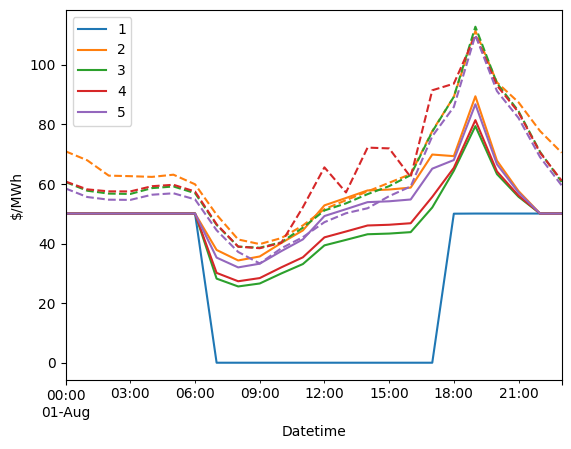

In [7]:
fig, ax = plt.subplots()
(model.profile.price/base).plot(ax=ax)
# Save colors for consistency
colors = np.array([line.get_color() for line in ax.lines])
ax.set_prop_cycle(None)
(model.profile.nom_price/base).plot(ax=ax,style='--',color=colors[model.profile.nom_price.columns-1],legend=False)
ax.set_ylabel('$/MWh')
fig.show()

Similar idea with the loads - nominal dotted, actual solid

C:\Users\elean\AppData\Local\Temp\ipykernel_12012\1584906060.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


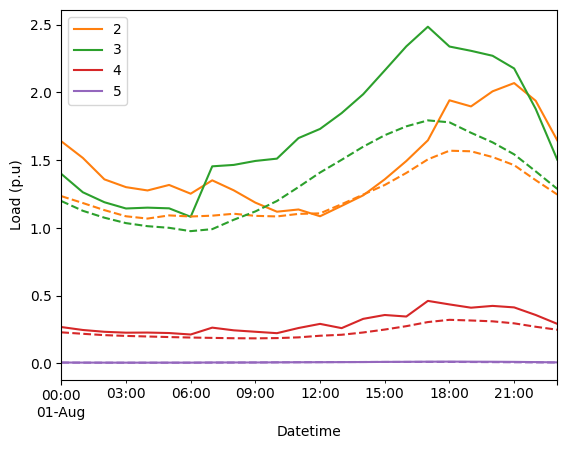

In [8]:
fig, ax = plt.subplots()
model.profile.load.plot(ax=ax,color=colors[model.profile.load.columns-1])
model.profile.nom_load.plot(ax=ax,style='--',color=colors[model.profile.load.columns-1],legend=False)
ax.set_ylabel('Load (p.u)')
fig.show()

Compute the dispatchable and intermittent (dotted) generation

C:\Users\elean\AppData\Local\Temp\ipykernel_12012\462886095.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


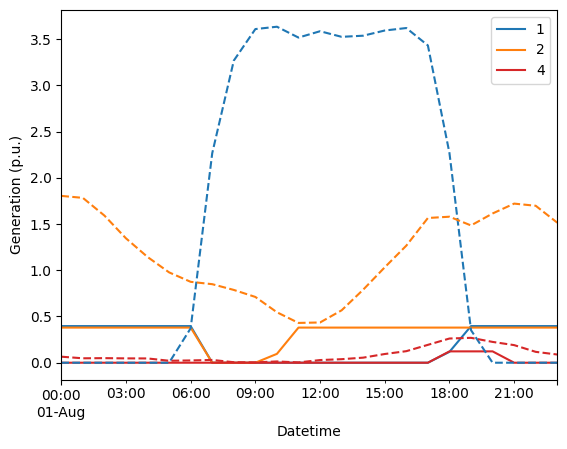

In [9]:
dispatchable = model.profile.generation - model.profile.int_gen
dispatchable[dispatchable < 0] = 0
intermittent = model.profile.generation - dispatchable

fig, ax = plt.subplots()
dispatchable.plot(ax=ax,color=colors[dispatchable.columns-1])
intermittent.plot(ax=ax,style='--',color=colors[intermittent.columns-1],legend=False)
ax.set_ylabel('Generation (p.u.)')
fig.show()

Compute producer (solid) and consumer (dashed) surplus according to:
- Producer surplus = revenue - cost
- Consumer surplus = utility - expenses

C:\Users\elean\AppData\Local\Temp\ipykernel_12012\1847973090.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


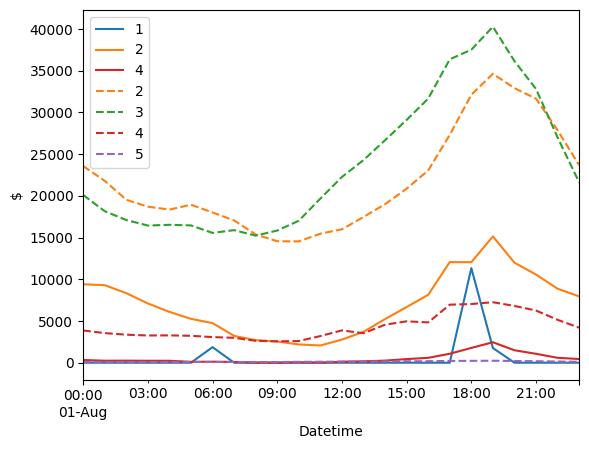

In [10]:
producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]

fig, ax = plt.subplots()
producer_surplus.plot(ax=ax,color=colors[producer_surplus.columns-1])
consumer_surplus.plot(ax=ax,style='--',color=colors[consumer_surplus.columns-1])
ax.set_ylabel('$')
fig.show()

Compute line loading, as a percentage. A negative value indicates power is flowing in the reverse direction with respect to the legend.

C:\Users\elean\AppData\Local\Temp\ipykernel_12012\3678432659.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


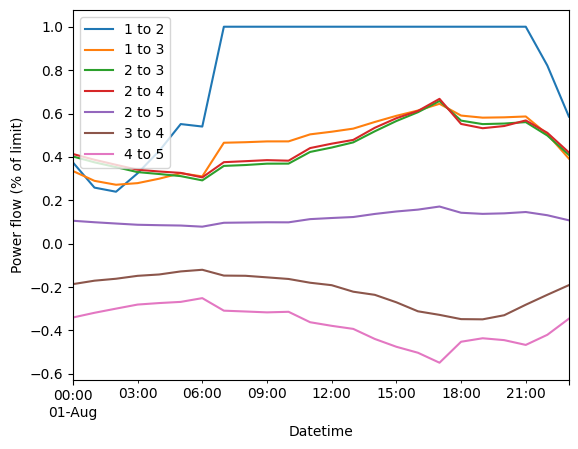

In [11]:
origin, destination = np.triu_indices(model.B.shape[0],1)
line_flows = model.profile.angle.apply(
    lambda row: pd.Series((model.B*outer_difference(row.to_numpy()))[(origin,destination)]),
    axis='columns'
)
line_flows.columns = [f'{origin[k]+1} to {destination[k]+1}' for k in range(len(line_flows.columns))]
lims = model.line_lims[(origin,destination)]
edge_idx = np.nonzero(lims)[0]
line_flows = line_flows.iloc[:,edge_idx]/lims[edge_idx]

fig, ax = plt.subplots()
line_flows.plot(ax=ax)
ax.set_ylabel('Power flow (% of limit)')
fig.show()

State-of-charge computation

C:\Users\elean\AppData\Local\Temp\ipykernel_12012\2969740726.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


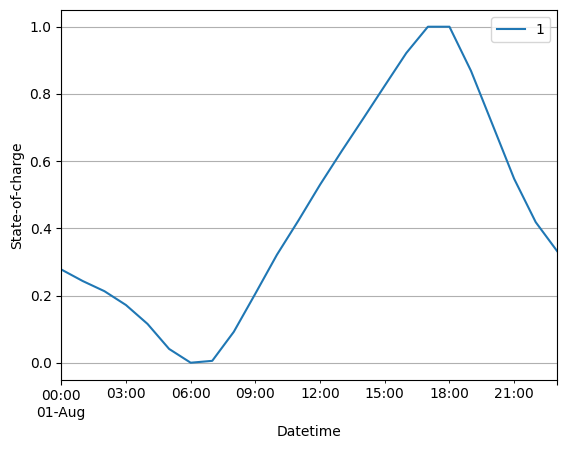

In [12]:
storage_mask = model.storage_capacity >= 1e-3
soc = model.initial_charge + model.profile.storage_load.cumsum()
soc = soc.loc[:,storage_mask]/model.storage_capacity[storage_mask]

fig, ax = plt.subplots()
soc.plot(ax=ax)
ax.set_ylabel('State-of-charge')
ax.grid()
fig.show()

Produce transition plots for nominal parameter values.

In [13]:
reset_to_nominal()
nom_results = {}
for t in np.linspace(0.0, 1.0, 11):
    print('Computing for transition = '+str(t)+'...')
    model.profile.int_gen = t*int_gen
    model.dis_max = (1-t)*installed/base
    model.total_storage = t*STORAGE_RATIO*installed.sum()/base
    model.solve()
    producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
    consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]
    dispatchable = model.profile.generation - model.profile.int_gen
    dispatchable[dispatchable < 0] = 0
    intermittent = model.profile.generation - dispatchable
    dispatchable_surplus = dispatchable*model.profile.price[dispatchable.columns]-model.profile.cost
    intermittent_surplus = intermittent*model.profile.price[intermittent.columns]
    nom_results[t] = pd.Series(
        {
            'load': base*model.profile.load.sum().sum(),
            'load_minus_nom': base*(model.profile.load - model.profile.nom_load).sum().sum(),
            'dispatchable': base*dispatchable.sum().sum(),
            'VRE': base*intermittent.sum().sum(),
            'dispatchable_surplus': dispatchable_surplus.sum().sum()/(1-t)/installed.sum(),
            'VRE_surplus': intermittent_surplus.sum().sum()/t/installed.sum(),
            'producer_surplus': producer_surplus.sum().sum()/installed.sum(),
            'average_price': model.profile.price.mean(axis=None)/base,
            'max_price': model.profile.price.max(axis=None)/base,
            'min_price': model.profile.price.min(axis=None)/base,
            'std_price': np.std(model.profile.price.to_numpy().flatten())/base
        }
    )
nom_results = pd.DataFrame(nom_results).T
nom_results.index.name = 'transition'
nom_results

Computing for transition = 0.0...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
C:\Users\elean\AppData\Local\Temp\ipykernel_12012\1628062544.py:23: RuntimeWarning: invalid value encountered in scalar divide
  'VRE_surplus': intermittent_surplus.sum().sum()/t/installed.sum(),


Computing for transition = 0.1...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 0.2...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 0.30000000000000004...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 0.4...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 0.5...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 0.6000000000000001...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 0.7000000000000001...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 0.8...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 0.9...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Computing for transition = 1.0...


C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
C:\Users\elean\AppData\Local\Temp\ipykernel_12012\1628062544.py:22: RuntimeWarning: invalid value encountered in scalar divide
  'dispatchable_surplus': dispatchable_surplus.sum().sum()/(1-t)/installed.sum(),


,load,load_minus_nom,dispatchable,VRE,dispatchable_surplus,VRE_surplus,producer_surplus,average_price,max_price,min_price,std_price
transition,,,,,,,,,,,
0.0,8745.647760,1959.979860,8745.647327,0.000000,26.053909,NaN,26.053909,47.150208,56.447045,4.402165e+01,2.796922
0.1,8834.949909,2049.282009,7805.155131,1029.795722,24.260451,347.857456,56.620152,46.570238,54.091431,4.344890e+01,2.750985
0.2,8919.053119,2133.385219,6859.461987,2059.591444,23.132478,341.643130,86.834608,46.073195,51.878076,4.287608e+01,2.873788
0.3,8981.342142,2195.674242,5891.959917,3089.387166,23.013505,337.245274,117.283036,45.697971,50.420870,4.230413e+01,3.185633
0.4,8984.241284,2198.573384,4865.058648,4119.182888,25.599257,331.859835,148.103488,45.587603,53.038396,4.101056e+01,3.725484
0.5,8880.581994,2094.914094,3731.597722,5148.978610,37.399695,304.712835,171.056265,45.725254,63.523973,3.375334e+01,6.585751
0.6,9101.624616,2315.956716,3263.663459,5837.960952,46.736459,157.666626,113.294559,42.175470,66.616274,1.329632e-06,15.016654
0.7,8983.751693,2198.083793,2583.063640,6400.687722,55.132343,159.433742,128.143322,42.566415,71.791276,9.725710e-07,15.531556
0.8,8805.558281,2019.890381,1865.299129,6940.259070,67.123866,155.354711,137.708542,43.034442,77.620125,4.887723e-08,16.629844


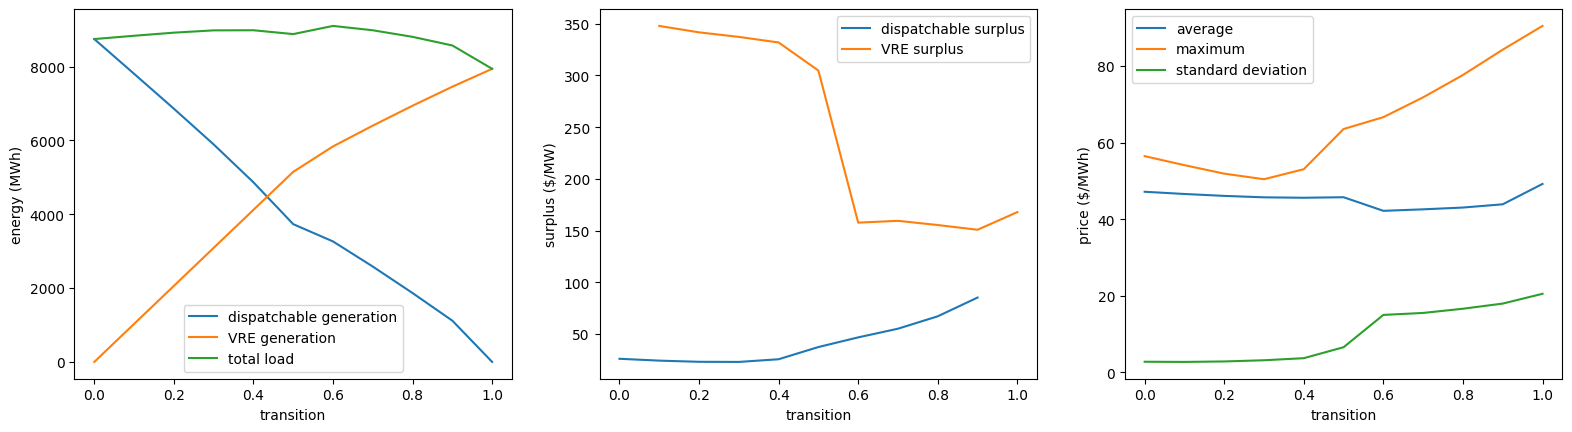

In [19]:
fig, ax = plt.subplots(1,3)
nom_results[['dispatchable','VRE','load']].plot(ax=ax[0])
nom_results[['dispatchable_surplus','VRE_surplus']].plot(ax=ax[1])
nom_results[['average_price','max_price','std_price']].plot(ax=ax[2])
[a.set_xlabel('transition') for a in ax]
ax[0].set_ylabel('energy (MWh)')
ax[0].legend(['dispatchable generation', 'VRE generation', 'total load'])
ax[1].set_ylabel('surplus ($/MW)')
ax[1].legend(['dispatchable surplus', 'VRE surplus'])
ax[2].set_ylabel('price ($/MWh)')
ax[2].legend(['average', 'maximum', 'standard deviation'])
fig.set_size_inches(fig.get_size_inches()*[3,1])

In [15]:
# Sensitivity plot functions 
def run_analysis(model, current_val, nominal_val):
    model.solve()
    producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
    dispatchable = model.profile.generation - model.profile.int_gen
    dispatchable[dispatchable < 0] = 0
    intermittent = model.profile.generation - dispatchable
    dispatchable_surplus = dispatchable*model.profile.price[dispatchable.columns]-model.profile.cost
    intermittent_surplus = intermittent*model.profile.price[intermittent.columns]
    output = pd.Series(
        {
            'producer_surplus': producer_surplus.sum().sum()/installed.sum(),
            'total_consumption': base*model.profile.load.sum().sum(),
            'average_price': model.profile.price.mean(axis=None)/base,
            'max_price': model.profile.price.max(axis=None)/base,
            'dispatchable_surplus': dispatchable_surplus.sum().sum()/(1-TRANSITION)/installed.sum(),
            'VRE_surplus': intermittent_surplus.sum().sum()/TRANSITION/installed.sum(),
            'xlabl': 100*(current_val/nominal_val - 1)
        }
    )
    return output

def sensitivity_plot(results):
    results = pd.DataFrame(results).T
    results.plot(y='producer_surplus', x='xlabl', ax=ax[0,0])
    results.plot(y="total_consumption", x="xlabl", ax=ax[0,1])
    results.plot(y="average_price", x="xlabl", ax=ax[1,0])
    results.plot(y="max_price", x="xlabl", ax=ax[1,1])
    results.plot(y='dispatchable_surplus', x='xlabl', ax=ax[2,0])
    results.plot(y='VRE_surplus', x='xlabl', ax=ax[2,1])

Produce sensitivity plots showing sensitivity of producer surplus, consumer surplus, and average price to parameter values.

C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reduct

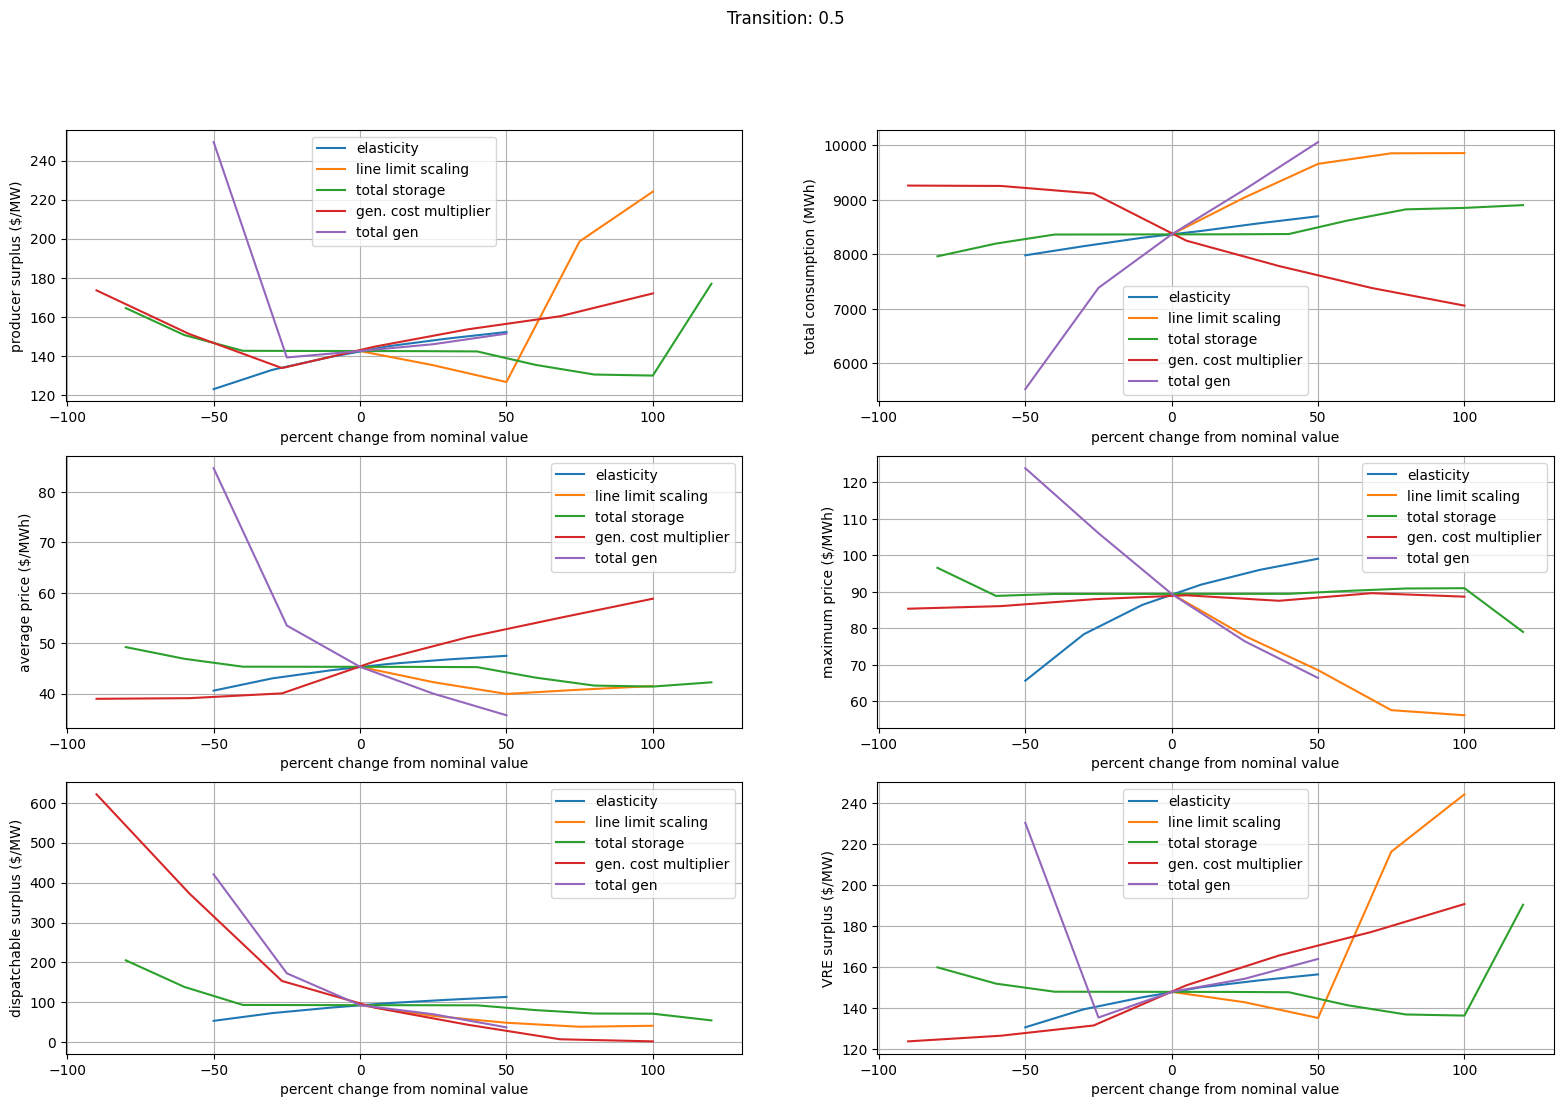

In [16]:
# Produce sensitivity plot - x axis is % change in input from its reference, y is measure of variable of interest.

fig, ax = plt.subplots(3,2)

# Set the transition 
transition = 0.5

# Vary elasticity 
results = {}
for i in np.linspace(0.5, 1.5, 6):
    reset_to_nominal()
    model.profile.elasticity = model.profile.elasticity*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# Line limit scaling 
results = {}
for i in np.linspace(1.0, 2.0, 5):
    reset_to_nominal()
    model.line_lims = P_line*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# Storage scaling
results = {}
for i in np.linspace(0.2, 2.2, 11):
    reset_to_nominal()
    model.total_storage = model.total_storage*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# generator costs  
results = {}
for i in np.linspace(0.1, 2.0, 7):
    reset_to_nominal()
    model.cost_coeffs = cost_coeffs*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# Total generation 
results = {}
for i in np.linspace(0.5, 1.5, 5):
    reset_to_nominal()
    model.profile.int_gen = model.profile.int_gen*i
    model.dis_max = model.dis_max*i
    model.total_storage = model.total_storage*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

[a.set_xlabel('percent change from nominal value') for row in ax for a in row]
ax[0,0].set_ylabel('producer surplus ($/MW)')
ax[0,1].set_ylabel('total consumption (MWh)')
ax[1,0].set_ylabel('average price ($/MWh)')
ax[1,1].set_ylabel('maximum price ($/MWh)')
ax[2,0].set_ylabel('dispatchable surplus ($/MW)')
ax[2,1].set_ylabel('VRE surplus ($/MW)')
fig.suptitle("Transition: "+str(transition))
[a.grid() for row in ax for a in row]
fig.set_size_inches(fig.get_size_inches()*[3,2.5])
[a.legend(['elasticity', 'line limit scaling', 'total storage', 'gen. cost multiplier', 'total gen']) for row in ax for a in row]

fig.show()

C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reduct

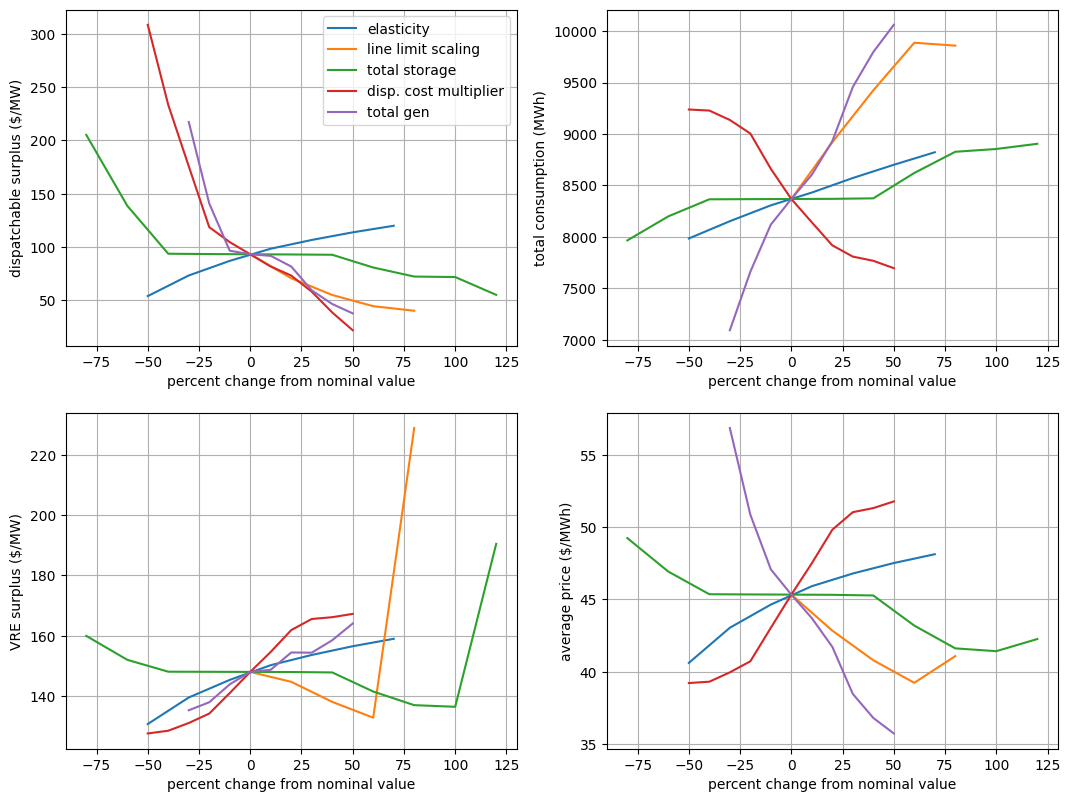

In [20]:
# square plot for overleaf 

fig, ax = plt.subplots(2,2)

def sensitivity_plot_small(results):
    results = pd.DataFrame(results).T

    results.plot(y='dispatchable_surplus', x='xlabl', ax=ax[0,0])
    results.plot(y='VRE_surplus', x='xlabl', ax=ax[1,0], legend=None)
    results.plot(y="total_consumption", x="xlabl", ax=ax[0,1], legend=None)
    results.plot(y="average_price", x="xlabl", ax=ax[1,1], legend=None)

# Set the transition 
transition = 0.9

# Vary elasticity 
results = {}
for i in np.linspace(0.5, 1.7, 7):
    reset_to_nominal()
    model.profile.elasticity = model.profile.elasticity*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

# Line limit scaling 
results = {}
for i in np.linspace(1.0, 1.8, 5):
    reset_to_nominal()
    model.line_lims = P_line*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

# Storage scaling
results = {}
for i in np.linspace(0.2, 2.2, 11):
    reset_to_nominal()
    model.total_storage = model.total_storage*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

# generator costs  
results = {}
for i in np.linspace(0.5, 1.5, 11):
    reset_to_nominal()
    model.cost_coeffs = cost_coeffs*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

# Total generation 
results = {}
for i in np.linspace(0.7, 1.5, 9):
    reset_to_nominal()
    model.profile.int_gen = model.profile.int_gen*i
    model.dis_max = model.dis_max*i
    model.total_storage = model.total_storage*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot_small(results)

[a.set_xlabel('percent change from nominal value') for row in ax for a in row]
ax[0,0].set_ylabel('dispatchable surplus ($/MW)')
ax[1,0].set_ylabel('VRE surplus ($/MW)')
ax[0,1].set_ylabel('total consumption (MWh)')
ax[1,1].set_ylabel('average price ($/MWh)')

#fig.suptitle("Transition: "+str(transition))
[a.grid() for row in ax for a in row]
fig.set_size_inches(fig.get_size_inches()*[2,2])
#[a.legend(['elasticity', 'line limit scaling', 'total storage', 'gen. cost multiplier', 'total gen']) for row in ax for a in row]
ax[0,0].legend(['elasticity', 'line limit scaling', 'total storage', 'disp. cost multiplier', 'total gen'])

fig.show()

C:\Users\elean\anaconda3\envs\prd_env\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
C:\Users\elean\AppData\Local\Temp\ipykernel_12012\915242902.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


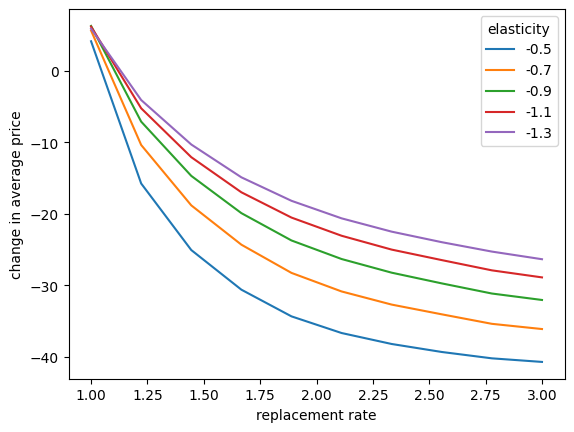

In [18]:
n_rates = 10
n_e = 5
prices = np.empty((n_e,n_rates,2))
elasticities = np.linspace(-.5,-1.3,n_e)
for k, e in enumerate(elasticities):
    for i,replacement_ratio in enumerate(np.linspace(1,5,n_rates)):
        for j,t in enumerate([0,1]):
            model = Network(
                B=B,
                line_lims=P_line,
                profile=profile,
                dis_max=dis_max,
                total_storage=total_storage,
                storage_cycle_timesteps=B_DURATION,
                cost_coeffs=cost_coeffs,
                cycle_storage=True
            )
            model.profile.elasticity = e
            model.profile.int_gen *= replacement_ratio*t
            model.total_storage *= replacement_ratio*t
            model.dis_max *= (1-t)
            model.solve()
            prices[k,i,j] = model.profile.price.mean().mean()

fig, ax = plt.subplots()
r = np.linspace(1,3,n_rates)
ax.plot(r, (prices[:,:,1] - prices[:,:,0]).T/base)
ax.set_xlabel('replacement rate')
ax.set_ylabel('change in average price')
ax.legend(elasticities.round(2),title='elasticity')
fig.show()